# Calculate p-values for each gene

The whack-a-probe optimization/training process results in a ranked list of genes where the gene's ranking is its only quantitative attribute. But we would like to report the probability we discovered any particular gene purely by chance, a p-value. To do this, we compare the average ranking each gene achieved in 16 split-half real data sets against the ranking the gene achieved in 256 runs of each of three permutation algorithms. A gene that was consistently ranked higher in real data than it was in shuffled data would have a low p-value.

$$p = {times gene ranked higher in permuation} \over 256$$

A second approach counts each individual real ranking (rather than averages) against each individual shuffled ranking, which is 4,096 comparisons.


In [1]:
""" Define some lists for looping. """
masks = ['00', '16', '32', '64', ]
shuffles = ["agno", "dist", "edge", ]

In [2]:
""" Load up the data, preprocessed by the ge_data_manager project.
    We won't use this to generate rankings, but we can see quickly
    where the peaks are in each run. """

import pickle

pre_calc_results = {}
for mask in masks:
    with open("/data/plots/cache/hcpww{}speak_ol_post.df".format(mask), "br") as f:
        pre_calc_results[mask] = pickle.load(f)
        derivatives = pre_calc_results[mask][pre_calc_results[mask]['shuffle'] == 'none']
        print("Peak for {} at {:,} +/- {:0.0f}".format(
            mask,
            15745 - int(derivatives['peak'].mean()),
            derivatives['peak'].std(),
        ))
        for shuffle in shuffles:
            shuffled = pre_calc_results[mask][pre_calc_results[mask]['shuffle'] == shuffle]
            print("     {} {} at {:,} +/- {:0.0f}".format(
                mask, shuffle,
                15745 - int(shuffled['peak'].mean()),
                shuffled['peak'].std(),
            ))


Peak for 00 at 72 +/- 18
     00 agno at 88 +/- 25
     00 dist at 79 +/- 24
     00 edge at 45 +/- 12
Peak for 16 at 72 +/- 14
     16 agno at 89 +/- 25
     16 dist at 79 +/- 24
     16 edge at 46 +/- 12
Peak for 32 at 77 +/- 14
     32 agno at 90 +/- 25
     32 dist at 78 +/- 23
     32 edge at 46 +/- 13
Peak for 64 at 69 +/- 17
     64 agno at 89 +/- 26
     64 dist at 78 +/- 23
     64 edge at 49 +/- 14


## Calculate p-values

Define functions to import all rankings into a single dataframe. Rank them all. Then calculate p-values. We calculate the old intensive way first, then add onto that dataframe with the faster vectorized method.

In [3]:
""" Modified from ge_data_manager to include shuffled data,
    the ranked_probes function iterates over result tsvs, ranking genes and saving them
    into a single dataframe. """

import pandas as pd
from pygest import algorithms
from pygest.convenience import bids_val
from pygest.rawdata import miscellaneous


def name_from_path(path):
    """ Extract critical pieces from the path to return an abbreviated column name.
        Three items differ in each path: 4 shuffle-types, 16 splits, 16 seeds (plus None). """
    
    shuffle = bids_val("shuffle", path)
    if shuffle == "random":
        shuffle = "agno" 
    if shuffle == "actual":
        shuffle = "real" 
    
    batch = bids_val("batch", path)[-3:]
    seed = bids_val("seed", path)[-3:]
    
    return "{}-{}-{}".format(shuffle, batch, seed)

    
def ranked_probes(tsvs, top):
    """ Go through the files provided, at the threshold specified, and report probes in all files. """

    report_progress_on_items = range(int(len(tsvs)/10), len(tsvs), int(len(tsvs)/10))
    all_rankings = pd.DataFrame()
    for i, tsv in enumerate(tsvs):
        df = pd.read_csv(tsv, sep='\t')
        rankings = pd.Series(data=df.index, index=df['probe_id'], name=name_from_path(tsv))
        if i == 0:
            all_rankings = pd.DataFrame(data=rankings)
        else:
            all_rankings[rankings.name] = rankings
        # if i in report_progress_on_items:
        #     print("Ranked {} of {} and counting...".format(i, len(tsvs)))
        if i == len(tsvs):
            print("    ranked all probes in {} results.".format(i + 1))
    all_rankings['mean'] = all_rankings.mean(axis=1)
    all_rankings['entrez_id'] = all_rankings.index.map(miscellaneous.map_pid_to_eid_fornito)
    return all_rankings.sort_values('mean', ascending=True)


In [4]:
""" Rank probes/genes for each and every run. """

rankings = {}
for mask in masks:
    tsv_files = pre_calc_results[mask]['path']
    rankings[mask] = ranked_probes(tsv_files, None)

In [5]:
""" We can borrow the id-to-symbol map from PyGEST.
    (although it would be better to build a reproducible routine to extract it from updated human_gene_info files.) """

from pygest import convenience

id_to_symbol_map = convenience.create_id_to_symbol_map()
for mask in masks:
    rankings[mask]['gene_symbol'] = rankings[mask]['entrez_id'].map(id_to_symbol_map)

In [6]:
""" Determine, for each probe/gene, how likely it is for a real ranking to be higher than a shuffled ranking.
    This is the c-style, expensive, 4k-comparison approach. """

import numpy as np

def p_probe(probe_id, df):
    """ Return probability (p-value) a real rank is higher than shuffled. """
    
    ps = {}
    real_runs = [c for c in df.columns if "real" in c]
    for shuf in ["agno", "dist", "edge", ]:
        shuffled_runs = [c for c in df.columns if shuf in c]

        n_better = 0
        n_worse = 0
        n_total = 0
        for real in df.loc[probe_id, real_runs]:
            for baseline in df.loc[probe_id, shuffled_runs]:
                n_total += 1
                if real < baseline:
                    n_better += 1
                else:
                    n_worse += 1
            # print("    {} vs {} of {}".format(n_better, n_worse, n_total))
        ps[shuf] = n_worse / n_total

        # print("Mean real rank = {:,} vs mean {} rank of {:,}; {:,} better, {:,} worse, out of {:,}; p = {:0.3f}".format(
        #     int(np.mean(df.loc[probe_id, real_runs])), shuf, int(np.mean(df.loc[probe_id, shuffled_runs])),
        #     n_better, n_worse, n_total, ps[shuf]
        # ))
        
    return ps["agno"], ps["dist"], ps["edge"]

In [7]:
""" Manually sample a few genes that came out in the prior algorithm as good, ok, and bad.
    Use just this small subset to rapidly prototype and check old vs new algorithms. """ 

# selected_ids = [57622, 8178, 728882, 10605, 23395, 1482, 9865, ]
# selected_ids = set(selected_ids).union(set(rankings["16"].sample(16)['entrez_id']))
# selected_probes = list(rankings["16"][rankings["16"]["entrez_id"].isin(selected_ids)]["entrez_id"].index)


' Manually sample a few genes that came out in the prior algorithm as good, ok, and bad.\n    Use just this small subset to rapidly prototype and check old vs new algorithms. '

In [8]:
""" Calculate p-values for real vs each of three shuffle types.
    This employs the c-style time intenstive process that performs ~4000 comparisons per gene. """

import pandas as pd
import datetime

df_p_values = {}
for mask in masks:
    print(datetime.datetime.now())
    p_values = {}
    print("Calculating p-values for {}mm-masked results.".format(mask))
    for pid in rankings[mask].index:  # replace me with selected_probes to limit how many genes are tested.
        p_a, p_d, p_e = p_probe(pid, rankings[mask])
        p_values[pid] = {
            'entrez_id': int(rankings[mask].loc[pid, 'entrez_id']),
            'gene_symbol': rankings[mask].loc[pid, 'gene_symbol'],
            'old_agno': p_a,
            'old_dist': p_d,
            'old_edge': p_e,
        }
    df_p_values[mask] = pd.DataFrame(data=p_values).T
    df_p_values[mask]['entrez_id'] = df_p_values[mask]['entrez_id'].astype(int)
    # df_p_values[mask] = df_p_values[mask].set_index('entrez_id')


2019-11-28 00:05:14.589929
Calculating p-values for 00mm-masked results.
2019-11-28 00:24:41.335270
Calculating p-values for 16mm-masked results.
2019-11-28 00:44:40.119669
Calculating p-values for 32mm-masked results.
2019-11-28 01:02:44.255453
Calculating p-values for 64mm-masked results.


In [9]:
""" Calculate p values by simply counting how many shuffled rankings are better
    than the average real ranking. This is only 256 comparisons. """

import numpy as np

for mask in masks:
    reals = rankings[mask].loc[:, [x for x in rankings[mask].columns if "real" in x]]
    real_means = reals.apply(np.mean, axis=1)

    for shuffle in shuffles:
        permuted_rankings = rankings[mask].loc[:, [x for x in rankings[mask].columns if shuffle in x]]
        hits = permuted_rankings.lt(real_means, axis=0)
        df_p_values[mask]['new_' + shuffle] = hits.sum(axis=1) / hits.count(axis=1)


TypeError: No loop matching the specified signature and casting was found for ufunc svd_n_s

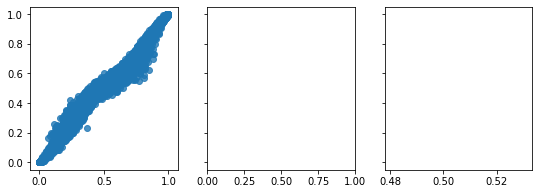

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

for mask in masks:
    fig, axes = plt.subplots(ncols=3, figsize=(9,3), sharey=True)
    sns.regplot(x="old_agno", y="new_agno", data=df_p_values[mask], ax=axes[0])
    sns.regplot(x="old_dist", y="new_dist", data=df_p_values[mask], ax=axes[1])
    sns.regplot(x="old_edge", y="new_edge", data=df_p_values[mask], ax=axes[2])
    fig.savefig("./old_vs_new_p_{}.png".format(mask))

In [11]:
df_p_values['32']

,entrez_id,gene_symbol,old_agno,old_dist,old_edge,new_agno,new_dist,new_edge
1039414,79048,SECISBP2,0.145752,0.881104,0.969727,0.156250,0.925781,0.992188
1051636,6451,SH3BGRL,0.302979,0.717285,0.953857,0.312500,0.769531,0.984375
1062385,6646,SOAT1,0.0273438,0.422363,0.916992,0.023438,0.457031,0.914062
1036637,92106,OXNAD1,0.107178,0.625488,0.726074,0.117188,0.691406,0.761719
1017071,58486,ZBED5,0.170166,0.64917,0.658936,0.175781,0.699219,0.773438
...,...,...,...,...,...,...,...,...
1051216,6663,SOX10,0.911865,0.709717,0.243164,0.894531,0.640625,0.089844
1031623,374907,B3GNT8,0.818604,0.527588,0.503174,0.742188,0.308594,0.238281
1047516,10350,ABCA9,0.729492,0.378174,0.0935059,0.667969,0.234375,0.015625
1018129,84968,PNMA6A,0.874512,0.66626,0.160156,0.750000,0.398438,0.000000


In [13]:
""" Define a kernel-density plot to assist in visualizing the distributions of rankings. """

import seaborn as sns
import matplotlib.pyplot as plt

flatten = lambda l: [x for y in l for x in y]

def plot_entrez_id(entrez_id, rank_data, p_data, algo):
    """ Plot ranking distributions for one entrez id. """
    fig, ax = plt.subplots()
    real_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "real" in x]].values)
    real_label = "real"
    sns.distplot(real_list, ax=ax, kde_kws={"color": "black", "label": real_label}, hist_kws={"color": "gray"})
    agno_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "agno" in x]].values)
    agno_label = "vs agno, p = {:0.5f}".format(p_data.loc[entrez_id, algo + '_agno'])
    sns.distplot(agno_list, ax=ax, kde_kws={"color": "green", "label": agno_label}, hist_kws={"color": "lightgreen"})
    dist_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "dist" in x]].values)
    dist_label = "vs dist, p = {:0.5f}".format(p_data.loc[entrez_id, algo + '_dist'])
    sns.distplot(dist_list, ax=ax, kde_kws={"color": "red", "label": dist_label}, hist_kws={"color": "mistyrose"})
    edge_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "edge" in x]].values)
    edge_label = "vs edge, p = {:0.5f}".format(p_data.loc[entrez_id, algo + '_edge'])
    sns.distplot(edge_list, ax=ax, kde_kws={"color": "magenta", "label": edge_label}, hist_kws={"color": "lavenderblush"})
    fig.suptitle("Entrez ID {} ({} p)".format(entrez_id, algo))
    return fig, ax

# f, a = plot_entrez_id(57622, rankings["16"], df_p_values["16"].set_index('entrez_id'))

In [14]:
""" Save out a csv file with entrez ids ordered by p-value for each mask and shuffle type. """

import random

for mask in masks:
    for algo in ["new", "old", ]:
        eids_all_good = set(df_p_values[mask]['entrez_id'])
        eids_all_bad = set(df_p_values[mask]['entrez_id'])
        for shuffle in shuffles:
            print("{} {}_{} {:,} probes with p < 0.05".format(
                mask, algo, shuffle, (df_p_values[mask][algo + "_" + shuffle] < 0.05).sum()
            ))
            for id in ["gene_symbol", "entrez_id", ]:
                df = df_p_values[mask][[id, algo + "_" + shuffle]].set_index(id).sort_values(algo + "_" + shuffle)
                df = df.rename(columns={algo + "_" + shuffle: "p"})
                df.to_csv("./hcpww{}s_{}_{}_p_by_{}.tsv".format(mask, algo, shuffle, id), sep="\t")

            eids_all_good = eids_all_good.intersection(set(df['p'][df['p'] < 0.05].index))
            eids_all_bad = eids_all_bad.intersection(set(df['p'][df['p'] >= 0.05].index))

        print("Mask {} has {} probes surviving all {} p-tests.".format(mask, len(eids_all_good), algo))
        print("    {}".format(sorted(list(eids_all_good))[:12]))
        eid_to_plot = random.sample(eids_all_good, 3)[0]
        f, a = plot_entrez_id(eid_to_plot, rankings[mask], df_p_values[mask].set_index('entrez_id'), algo)
        f.savefig("good_{}_{}.png".format(mask, eid_to_plot))
        f.clear()

        print("Mask {} has {} probes failing all {} p-tests.".format(mask, len(eids_all_bad), algo))
        print("    {}".format(sorted(list(eids_all_bad))[:12]))
        eid_to_plot = random.sample(eids_all_bad, 3)[0]
        f, a = plot_entrez_id(eid_to_plot, rankings[mask], df_p_values[mask].set_index('entrez_id'), algo)    
        f.savefig("bad_{}_{}.png".format(mask, eid_to_plot))
        f.clear()


00 new_agno 369 probes with p < 0.05
00 new_dist 44 probes with p < 0.05
00 new_edge 3,939 probes with p < 0.05
Mask 00 has 5 probes surviving all new p-tests.
    [9607, 9734, 57622, 80036, 130367]
Mask 00 has 11610 probes failing all new p-tests.
    [1, 2, 12, 16, 18, 19, 20, 21, 22, 23, 25, 27]
00 old_agno 331 probes with p < 0.05
00 old_dist 11 probes with p < 0.05
00 old_edge 2,441 probes with p < 0.05
Mask 00 has 6 probes surviving all old p-tests.
    [9607, 9734, 10451, 10714, 57622, 80036]
Mask 00 has 13112 probes failing all old p-tests.
    [1, 2, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25]
16 new_agno 361 probes with p < 0.05
16 new_dist 51 probes with p < 0.05
16 new_edge 3,910 probes with p < 0.05
Mask 16 has 5 probes surviving all new p-tests.
    [9607, 9734, 57622, 80036, 130367]
Mask 16 has 11636 probes failing all new p-tests.
    [1, 2, 12, 16, 18, 19, 20, 21, 22, 23, 25, 27]
16 old_agno 333 probes with p < 0.05
16 old_dist 10 probes with p < 0.05
16 old_edge 2,404 pro

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
""" No longer necessary
    This was written to convert an old csv format to tsv, but all current files are already tsv. """

import pandas as pd
import os

for mask in masks:
    for shuffle in shuffles:
        for p_algo in ["new", "old", ]:
            filename = "./hcpww{}s_{}_{}_p".format(mask, p_algo, shuffle)
            if os.path.isfile(filename + ".csv"):
                print("Converting {}".format(filename))
                df = pd.read_csv(filename + ".csv", index_col=0)
                df.to_csv(filename + ".tsv", sep="\t")